In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint

# Referat 1

# Adaptivne riadenie

In [2]:
def fcn_LTIS(x, t, A, b, u):
    dotx = np.matmul(A, x) + np.matmul(b, u)
    return dotx                                                ### cellE c01 ###

def fcn_simSch2 ( t_start , T_s , finalIndex , sig_r_ext ):

    A_m = np.array([[-1]])
    b_m = np.array([[1]])

    A = np.array([[-0.55]])
    b = np.array([[1]])
    c = np.array([[1]])

    #-----------------------------------------
    t_log = np.zeros([finalIndex, 1])
    t_log[0,:] = t_start

    #-----------------------------------------
    x_m_0 = np.array([0])

    x_m_log = np.zeros([finalIndex, len(x_m_0)])
    x_m_log[0,:] = x_m_0

    #-------------------------
    x_0 = np.array([0])

    x_log = np.zeros([finalIndex, len(x_0)])
    x_log[0,:] = x_0
    print(np.shape(x_log))
    y_log = np.zeros([finalIndex, 1])
    y_log[0,:] = np.dot(c, x_0)

    #-------------------------
    u_log = np.zeros([finalIndex, 1])
    u_log[0,:] = 0

    xf1_log = np.zeros([finalIndex, 1])
    xf2_log = np.zeros([finalIndex, 1])

    Theta_log = np.zeros([finalIndex, 2])
    # −−−−−−−−−−−−−−−−−−−−−−−−−−−−−−−−−−−−−−−−−
    timespan = np.zeros(2)
    for idx in range(1, int(finalIndex)):

        timespan[0] = t_log[idx-1,:]
        timespan[1] = t_log[idx-1,:] + T_s

        t_log[idx,:] = timespan[-1]

        # ------------
        # Referencny model realizovany pomocou riadneho ode solevera
        # Takyto ode solver nemusi byt vzdy dostupny z pohladu implemetnacie riadiaceho systemu

        odeOut = odeint(fcn_LTIS,
                        x_m_log[idx-1,:],
                        timespan,
                        args=(A_m, b_m, sig_r_ext[idx-1,:])
                        )

        x_m_log[idx,:] = odeOut[-1,:]

        # ------------
        odeOut = odeint(fcn_LTIS,
                        x_log[idx-1,:],
                        timespan,
                        args=(A, b, u_log[idx-1,:])
                        )

        x_log[idx,:] = odeOut[-1,:]
        y_log[idx,:] = np.dot(c, x_log[idx,:])

        # -------------------------
        alpha = 0.5

        omega = np.array([sig_r_ext[idx-1,:], y_log[idx-1,:]])
        adaptErr = y_log[idx-1, 0] - x_m_log[idx-1, 0]

        # Tu je numericka integracia realizovana jednoducho sumatorom - treba teda dbat na krok integrovania - teda tu to, co volame periodou vzorkovania
        dxf1 = np.dot(A_m, xf1_log[idx-1,:]) + np.dot(b_m, [omega[0,0]])
        xf1_log[idx,:] = xf1_log[idx-1,:] + dxf1 * T_s
        dTheta_1 = -alpha * adaptErr * xf1_log[idx-1,:]

        dxf2 = np.matmul(A_m, xf2_log[idx-1,:]) + np.matmul(b_m, [omega[1,0]])
        xf2_log[idx,:] = xf2_log[idx-1,:] + dxf2 * T_s
        dTheta_2 = -alpha * adaptErr * xf2_log[idx-1,:]

        Theta_log[idx,:] = np.array([
            Theta_log[idx-1, 0] + dTheta_1 * T_s,
            Theta_log[idx-1, 1] + dTheta_2 * T_s,
        ]).T


        u_log[idx,:] = np.dot(Theta_log[idx-1,:], omega)

    return [t_log, x_m_log, x_log, y_log, u_log, Theta_log]

In [3]:
# Nastavenia simulacie

sim_t_start = 0
sim_t_final = 100
sim_T_s = 0.005
sim_finalIndex = int(((sim_t_final - sim_t_start)/sim_T_s) + 1)

# Preddefinovane signaly

period_time = 20
period_tab = np.array([
                      [0, 1],
                      [10, -1],
                      ])

sig_vysl = np.zeros([sim_finalIndex, 1])

for period in range(int(sim_t_final/period_time) + 1):


    for idx in range( int((period*period_time)/sim_T_s), int((period*period_time + period_time)/sim_T_s)):

        lastValue = period_tab[:,1][(period_tab[:,0] + (period*period_time))<=idx*sim_T_s ][-1]
        try:
            sig_vysl[idx] = lastValue
        except:
            break

sig_r_ext = sig_vysl

# Spustenie simulacie

t_log, x_m_log, x_log, y_log, u_log, Theta_log = fcn_simSch2(
    sim_t_start,
    sim_T_s,
    sim_finalIndex,
    sig_r_ext,
    )    

(20001, 1)


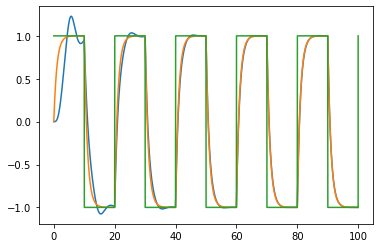

In [4]:
plt.plot(t_log,y_log)
plt.plot(t_log,x_m_log)
plt.plot(t_log,sig_r_ext)

# Moje

In [84]:
import numpy as np
from scipy.integrate import odeint

import sys

# %% ---------------------------------------------------------------------------

#import plantFcns
def plantFcns(x, t, A, b, u):
    dotx = np.dot(A, x) + np.dot(b, u)
    return dotx   


def fcn_simSch2(t_start, T_s, finalIndex, sig_r_ext):

    #-----------------------------------------

    par_L = 161.0
    par_K_0 = -3.86
    par_tau_10 = 5.66
    #par_v = 4.0
    
    
    par_K = par_K_0 * (par_v/par_L)
    par_tau_1 = par_tau_10 * (par_L/par_v)

    par_b_0 = par_K/par_tau_1
    par_a_1 = 1.0/par_tau_1

    A = np.array([[0, 1], [0, -par_a_1]])
    b = np.array([[0], [par_b_0]])
    c = np.array([[1], [0]])

    A_m = np.array([[0, 1], [-0.0025, -0.1]])
    b_m = np.array([[0], [0.0025]])

    #-----------------------------------------
    t_log = np.zeros([finalIndex, 1])
    t_log[0,:] = t_start

    #-----------------------------------------
    x_m_0 = np.zeros(b_m.shape[0])

    x_m_log = np.zeros([finalIndex, len(x_m_0)])
    x_m_log[0,:] = x_m_0

    #-------------------------
    x_0 = np.zeros(b.shape[0])

    x_log = np.zeros([finalIndex, len(x_0)])
    x_log[0,:] = x_0

    y_log = np.zeros([finalIndex, 1])
    y_log[0,:] = np.dot(c.T, x_0.reshape(-1,1))
    
    #-------------------------
    u_log = np.zeros([finalIndex, 1])
    u_log[0,:] = 0

    xf1_log = np.zeros([finalIndex, b_m.shape[0]])
    xf2_log = np.zeros([finalIndex, b_m.shape[0]])


    Theta_log = np.zeros([finalIndex, 2])
    Theta_log[0,:] = np.array([-3.8009, -143.6921])*0

    err = np.zeros([finalIndex, 1])
    err[0,:] = 0

    #-----------------------------------------
    timespan = np.zeros(2)
    for idx in range(1, int(finalIndex)):
        timespan[0] = t_log[idx-1,:]
        timespan[1] = t_log[idx-1,:] + T_s

        t_log[idx,:] = timespan[-1]

        # ------------

        odeOut = odeint(plantFcns,
                        x_log[idx-1,:],
                        timespan,
                        args=(A, b, u_log[idx-1,:])
                        )

        x_log[idx,:] = odeOut[-1,:]

        y_log[idx,:] = np.dot(c.T, x_log[idx,:].reshape(-1,1))

        # -------------------------

        # dxm = np.matmul(A_m, x_m_log[idx-1,:]) + np.matmul(b_m, [sig_r_ext[idx-1,:]])
        dxm = np.add(np.matmul(A_m, x_m_log[idx-1,:].reshape(-1,1)),
                     b_m * sig_r_ext[idx-1,:]
                     )

        x_m_log[idx,:] = x_m_log[idx-1,:] + dxm.reshape(1,-1)[0] * T_s

        # ------------

        alpha_1 = -0.025
        alpha_2 = -25


        # print -x_log[idx-1,1]

        omega = np.array([sig_r_ext[idx-1,:] - y_log[idx-1,:], [-x_log[idx-1,1]]])
        adaptErr = (y_log[idx-1, 0] - x_m_log[idx-1, 0])
        err[idx,:]=adaptErr



        # dxf1 = np.matmul(A_m, xf1_log[idx-1,:]) + np.matmul(b_m, [omega[0,0]])
        dxf1 = np.add(np.matmul(A_m, xf1_log[idx-1,:].reshape(-1,1)),
                     (b_m/b_m[1]) * omega[0,0]
                     )
        xf1_log[idx,:] = xf1_log[idx-1,:] + dxf1.reshape(1,-1)[0] * T_s
        dTheta_1 = -alpha_1 * adaptErr * np.dot([1, 0], xf1_log[idx-1,:].reshape(-1,1))


        dxf2 = np.add(np.matmul(A_m, xf2_log[idx-1,:].reshape(-1,1)),
                     (b_m/b_m[1]) * omega[1,0]
                     )
        xf2_log[idx,:] = xf2_log[idx-1,:] + dxf2.reshape(1,-1)[0] * T_s
        dTheta_2 = -alpha_2 * adaptErr * np.dot([1, 0], xf2_log[idx-1,:].reshape(-1,1))


        Theta_log[idx,:] = np.array([
            Theta_log[idx-1, 0] + dTheta_1 * T_s,
            Theta_log[idx-1, 1] + dTheta_2 * T_s,
        ]).T


        u_log[idx,:] = np.dot(Theta_log[idx-1,:], omega)
        


    return [t_log, x_m_log, x_log, y_log, u_log, Theta_log, xf1_log, xf2_log, err]

In [94]:
sim_t_start = 0
sim_t_final = 3000
sim_T_s = 0.5
sim_finalIndex = int(((sim_t_final - sim_t_start)/sim_T_s) + 1)

#--------------------

# Preddefinovane signaly

period_time = 1000
period_tab = np.array([
                      [0, 5.0*np.pi/180],
                      [250, 0],
                      [500, -5.0*np.pi/180],
                      [750, 0],
                      ])

sig_vysl = np.zeros([sim_finalIndex, 1])

for period in range(int(sim_t_final/period_time) + 1):


    for idx in range( int((period*period_time)/sim_T_s), int((period*period_time + period_time)/sim_T_s)):

        lastValue = period_tab[:,1][(period_tab[:,0] + (period*period_time))<=idx*sim_T_s ][-1]
        try:
            sig_vysl[idx] = lastValue
        except:
            break


# %% --------------------------------------------------------------------------

sig_r_ext = sig_vysl

# %% ---------------------------------------------------------------------------

par_v = 6

# Spustenie simulacie

t_log, x_m_log, x_log, y_log, u_log, Theta_log, xf1_log, xf2_log,err = fcn_simSch2(
    sim_t_start,
    sim_T_s,
    sim_finalIndex,
    sig_r_ext,
    )


In [91]:
y_log5=y_log
x_m_log5=x_m_log
x_log5=x_log
Theta_log5=Theta_log
xf1_log5=xf1_log
xf2_log5=xf2_log
u_log5=u_log
err5=err

In [93]:
y_log4=y_log
x_m_log4=x_m_log
x_log4=x_log
Theta_log4=Theta_log
xf1_log4=xf1_log
xf2_log4=xf2_log
u_log4=u_log
err4=err

In [95]:
y_log6=y_log
x_m_log6=x_m_log
x_log6=x_log
Theta_log6=Theta_log
xf1_log6=xf1_log
xf2_log6=xf2_log
u_log6=u_log
err6=err

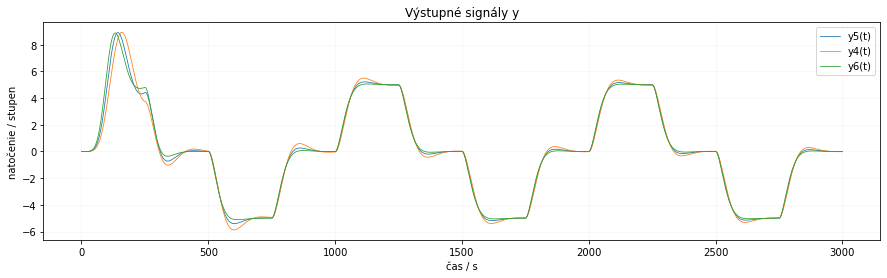

In [96]:
plt.figure(figsize=(15, 4))
plt.plot(t_log,y_log5*180/np.pi,linewidth=0.8)
plt.plot(t_log,y_log4*180/np.pi, linewidth=0.8)
plt.plot(t_log,y_log6*180/np.pi, linewidth=0.8)

plt.xlabel('čas / s')
plt.ylabel('natočenie / stupen')
plt.legend(['y5(t)','y4(t)','y6(t)'])
plt.title('Výstupné signály y')
plt.grid(alpha=0.1)

plt.savefig('C:/Users/Niki/Downloads/ADRIA-master/ADRIA-master/doc/AR04_txt_MRAC_gradientny/signal1all.png')

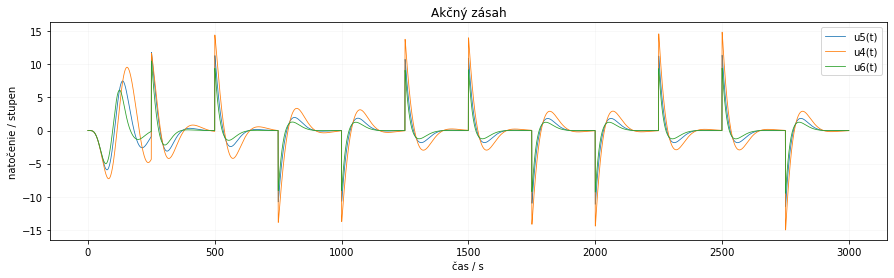

In [97]:
plt.figure(figsize=(15, 4))
plt.plot(t_log,u_log5*180/np.pi,linewidth=0.8)
plt.plot(t_log,u_log4*180/np.pi, linewidth=0.8)
plt.plot(t_log,u_log6*180/np.pi, linewidth=0.8)

plt.xlabel('čas / s')
plt.ylabel('natočenie / stupen')
plt.legend(['u5(t)','u4(t)','u6(t)'])
plt.title('Akčný zásah')
plt.grid(alpha=0.1)

plt.savefig('C:/Users/Niki/Downloads/ADRIA-master/ADRIA-master/doc/AR04_txt_MRAC_gradientny/signalall.png')

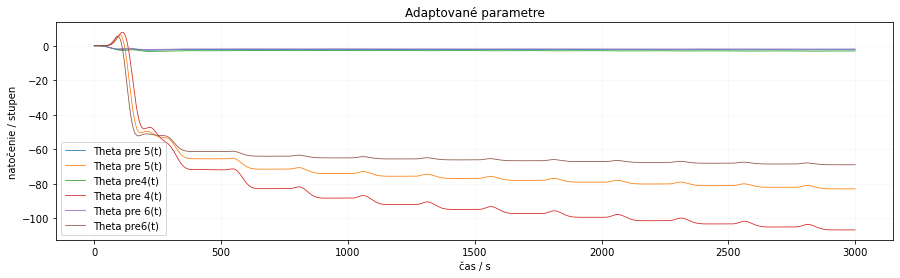

In [98]:
plt.figure(figsize=(15, 4))
plt.plot(t_log,Theta_log5,linewidth=0.8)
plt.plot(t_log,Theta_log4, linewidth=0.8)
plt.plot(t_log,Theta_log6, linewidth=0.8)

plt.xlabel('čas / s')
plt.ylabel('natočenie / stupen')
plt.legend(['Theta pre 5(t)','Theta pre 5(t)','Theta pre4(t)','Theta pre 4(t)','Theta pre 6(t)','Theta pre6(t)'])
plt.title('Adaptované parametre')
plt.grid(alpha=0.1)

plt.savefig('C:/Users/Niki/Downloads/ADRIA-master/ADRIA-master/doc/AR04_txt_MRAC_gradientny/signal3all.png')

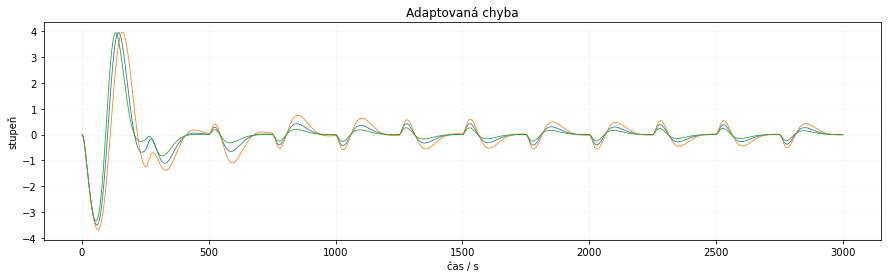

In [102]:
plt.figure(figsize=(15, 4))
plt.plot(t_log,err5*180/np.pi,linewidth=0.8)
plt.plot(t_log,err4*180/np.pi,linewidth=0.8)
plt.plot(t_log,err6*180/np.pi,linewidth=0.8)



plt.xlabel('čas / s')
plt.ylabel('stupeň')
plt.title('Adaptovaná chyba')
plt.grid(alpha=0.1)
plt.savefig('C:/Users/Niki/Downloads/ADRIA-master/ADRIA-master/doc/AR04_txt_MRAC_gradientny/chybaall.png')

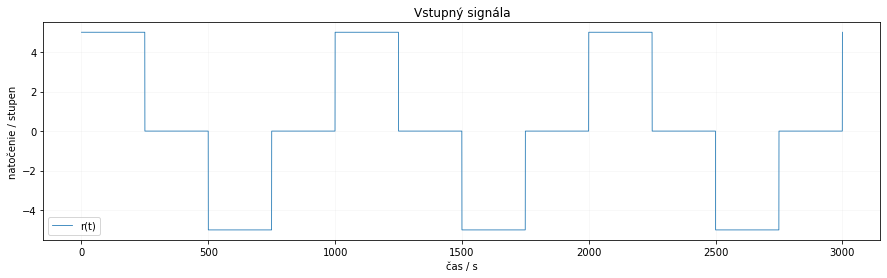

In [18]:
plt.figure(figsize=(15, 4))
plt.plot(t_log,sig_r_ext*180/np.pi,linewidth=0.8)


plt.xlabel('čas / s')
plt.ylabel('natočenie / stupeň')
plt.legend(['r(t)'])
plt.title('Vstupný signála')
plt.grid(alpha=0.1)

plt.savefig('C:/Users/Niki/Downloads/ADRIA-master/ADRIA-master/doc/AR04_txt_MRAC_gradientny/vstup.png')

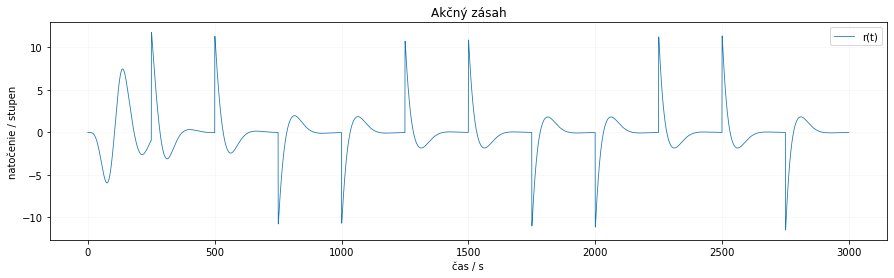

In [19]:
plt.figure(figsize=(15, 4))
plt.plot(t_log,u_log5*180/np.pi, linewidth=0.8)
plt.xlabel('čas / s')
plt.ylabel('natočenie / stupen')
plt.legend(['r(t)','ym(t)','y(t)'])
plt.title('Akčný zásah')
plt.grid(alpha=0.1)

plt.savefig('C:/Users/Niki/Downloads/ADRIA-master/ADRIA-master/doc/AR04_txt_MRAC_gradientny/zasah.png')

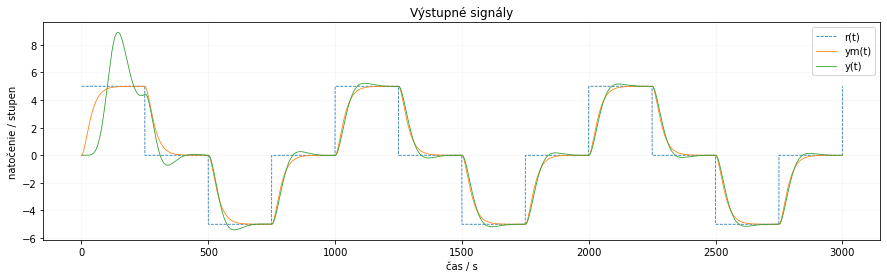

In [20]:
plt.figure(figsize=(15, 4))
plt.plot(t_log,sig_r_ext*180/np.pi, '--',linewidth=0.8)
plt.plot(t_log,x_m_log5[:,0]*180/np.pi, linewidth=0.8)
plt.plot(t_log,y_log5*180/np.pi, linewidth=0.8)

plt.xlabel('čas / s')
plt.ylabel('natočenie / stupen')
plt.legend(['r(t)','ym(t)','y(t)'])
plt.title('Výstupné signály')
plt.grid(alpha=0.1)

plt.savefig('C:/Users/Niki/Downloads/ADRIA-master/ADRIA-master/doc/AR04_txt_MRAC_gradientny/signal.png')

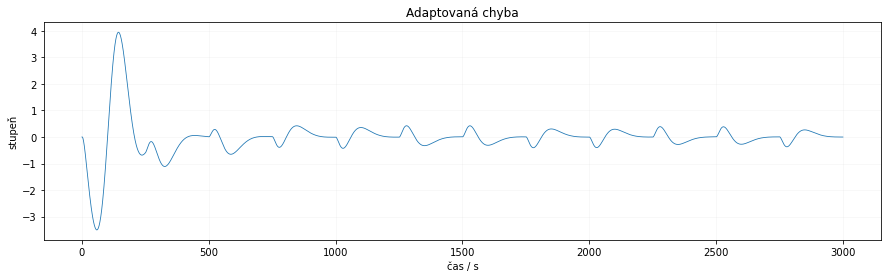

In [101]:
plt.figure(figsize=(15, 4))
plt.plot(t_log,err5*180/np.pi,linewidth=0.8)


plt.xlabel('čas / s')
plt.ylabel('stupeň')
plt.title('Adaptovaná chyba')
plt.grid(alpha=0.1)
plt.savefig('C:/Users/Niki/Downloads/ADRIA-master/ADRIA-master/doc/AR04_txt_MRAC_gradientny/chyba5.png')

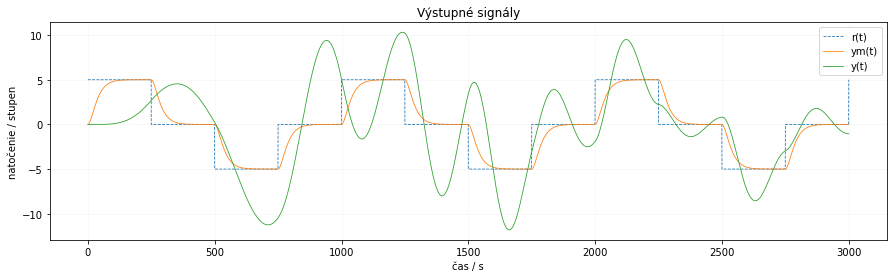

In [45]:
plt.figure(figsize=(15, 4))
plt.plot(t_log,sig_r_ext*180/np.pi, '--',linewidth=0.8)
plt.plot(t_log,x_m_log[:,0]*180/np.pi, linewidth=0.8)
plt.plot(t_log,y_log5*180/np.pi, linewidth=0.8)

plt.xlabel('čas / s')
plt.ylabel('natočenie / stupen')
plt.legend(['r(t)','ym(t)','y(t)'])
plt.title('Výstupné signály')
plt.grid(alpha=0.1)



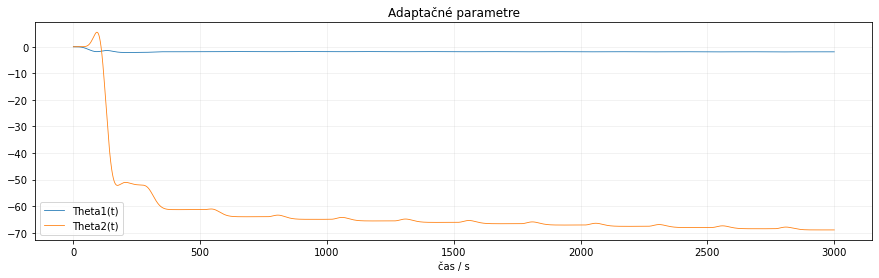

In [21]:
plt.figure(figsize=(15, 4))
plt.plot(t_log, Theta_log, linewidth=0.8)
plt.xlabel('čas / s')
plt.legend(['Theta1(t)','Theta2(t)'])
plt.title('Adaptačné parametre')
plt.grid(alpha=0.2)
plt.savefig('C:/Users/Niki/Downloads/ADRIA-master/ADRIA-master/doc/AR04_txt_MRAC_gradientny/theta.png')

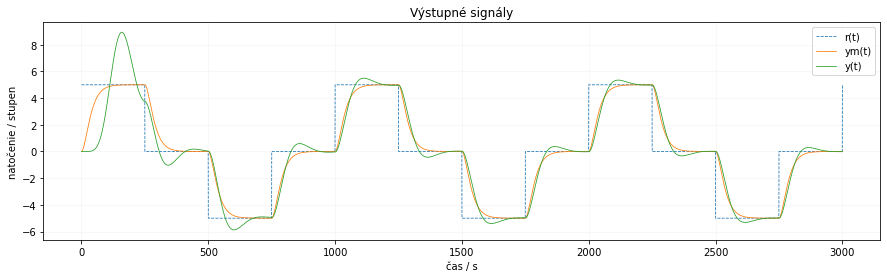

In [125]:
plt.figure(figsize=(15, 4))
plt.plot(t_log,sig_r_ext*180/np.pi, '--',linewidth=0.8)
plt.plot(t_log,x_m_log[:,0]*180/np.pi, linewidth=0.8)
plt.plot(t_log,y_log*180/np.pi, linewidth=0.8)

plt.xlabel('čas / s')
plt.ylabel('natočenie / stupen')
plt.legend(['r(t)','ym(t)','y(t)'])
plt.title('Výstupné signály')
plt.grid(alpha=0.1)

plt.savefig('signal.png')

# Zmena v pocas simulacie

In [22]:
def plantFcns(x, t, A, b, u):
    dotx = np.dot(A, x) + np.dot(b, u)
    return dotx   


def fcn_simSch2(t_start, T_s, finalIndex, sig_r_ext):

    #-----------------------------------------

    par_L = 161.0
    par_K_0 = -3.86
    par_tau_10 = 5.66
    par_v = 6.0
    
    
    par_K = par_K_0 * (par_v/par_L)
    par_tau_1 = par_tau_10 * (par_L/par_v)

    par_b_0 = par_K/par_tau_1
    par_a_1 = 1.0/par_tau_1

    A = np.array([[0, 1], [0, -par_a_1]])
    b = np.array([[0], [par_b_0]])
    c = np.array([[1], [0]])

    A_m = np.array([[0, 1], [-0.0025, -0.1]])
    b_m = np.array([[0], [0.0025]])

    #-----------------------------------------
    t_log = np.zeros([finalIndex, 1])
    t_log[0,:] = t_start

    #-----------------------------------------
    x_m_0 = np.zeros(b_m.shape[0])

    x_m_log = np.zeros([finalIndex, len(x_m_0)])
    x_m_log[0,:] = x_m_0

    #-------------------------
    x_0 = np.zeros(b.shape[0])

    x_log = np.zeros([finalIndex, len(x_0)])
    x_log[0,:] = x_0

    y_log = np.zeros([finalIndex, 1])
    y_log[0,:] = np.dot(c.T, x_0.reshape(-1,1))
    
    #-------------------------
    u_log = np.zeros([finalIndex, 1])
    u_log[0,:] = 0

    xf1_log = np.zeros([finalIndex, b_m.shape[0]])
    xf2_log = np.zeros([finalIndex, b_m.shape[0]])


    Theta_log = np.zeros([finalIndex, 2])
    Theta_log[0,:] = np.array([-3.8009, -143.6921])*0



    #-----------------------------------------
    timespan = np.zeros(2)
    for idx in range(1, int(finalIndex)):
        #-----------------------------------
        
        if(idx>=3000):
            par_v = 4.0

            par_K = par_K_0 * (par_v/par_L)
            par_tau_1 = par_tau_10 * (par_L/par_v)

            par_b_0 = par_K/par_tau_1
            par_a_1 = 1.0/par_tau_1

            A = np.array([[0, 1], [0, -par_a_1]])
            b = np.array([[0], [par_b_0]])
            c = np.array([[1], [0]])

            A_m = np.array([[0, 1], [-0.0025, -0.1]])
            b_m = np.array([[0], [0.0025]])
        #-----------------------------------
        timespan[0] = t_log[idx-1,:]
        timespan[1] = t_log[idx-1,:] + T_s

        t_log[idx,:] = timespan[-1]

        # ------------

        odeOut = odeint(plantFcns,
                        x_log[idx-1,:],
                        timespan,
                        args=(A, b, u_log[idx-1,:])
                        )

        x_log[idx,:] = odeOut[-1,:]

        y_log[idx,:] = np.dot(c.T, x_log[idx,:].reshape(-1,1))

        # -------------------------

        # dxm = np.matmul(A_m, x_m_log[idx-1,:]) + np.matmul(b_m, [sig_r_ext[idx-1,:]])
        dxm = np.add(np.matmul(A_m, x_m_log[idx-1,:].reshape(-1,1)),
                     b_m * sig_r_ext[idx-1,:]
                     )

        x_m_log[idx,:] = x_m_log[idx-1,:] + dxm.reshape(1,-1)[0] * T_s

        # ------------

        alpha_1 = -0.025
        alpha_2 = -25


        # print -x_log[idx-1,1]

        omega = np.array([sig_r_ext[idx-1,:] - y_log[idx-1,:], [-x_log[idx-1,1]]])
        adaptErr = (y_log[idx-1, 0] - x_m_log[idx-1, 0])



        # dxf1 = np.matmul(A_m, xf1_log[idx-1,:]) + np.matmul(b_m, [omega[0,0]])
        dxf1 = np.add(np.matmul(A_m, xf1_log[idx-1,:].reshape(-1,1)),
                     (b_m/b_m[1]) * omega[0,0]
                     )
        xf1_log[idx,:] = xf1_log[idx-1,:] + dxf1.reshape(1,-1)[0] * T_s
        dTheta_1 = -alpha_1 * adaptErr * np.dot([1, 0], xf1_log[idx-1,:].reshape(-1,1))


        dxf2 = np.add(np.matmul(A_m, xf2_log[idx-1,:].reshape(-1,1)),
                     (b_m/b_m[1]) * omega[1,0]
                     )
        xf2_log[idx,:] = xf2_log[idx-1,:] + dxf2.reshape(1,-1)[0] * T_s
        dTheta_2 = -alpha_2 * adaptErr * np.dot([1, 0], xf2_log[idx-1,:].reshape(-1,1))


        Theta_log[idx,:] = np.array([
            Theta_log[idx-1, 0] + dTheta_1 * T_s,
            Theta_log[idx-1, 1] + dTheta_2 * T_s,
        ]).T


        u_log[idx,:] = np.dot(Theta_log[idx-1,:], omega)


    return [t_log, x_m_log, x_log, y_log, u_log, Theta_log, xf1_log, xf2_log]

In [23]:
sim_t_start = 0
sim_t_final = 3000
sim_T_s = 0.5
sim_finalIndex = int(((sim_t_final - sim_t_start)/sim_T_s) + 1)

#--------------------

# Preddefinovane signaly

period_time = 1000
period_tab = np.array([
                      [0, 5.0*np.pi/180],
                      [250, 0],
                      [500, -5.0*np.pi/180],
                      [750, 0],
                      ])

sig_vysl = np.zeros([sim_finalIndex, 1])

for period in range(int(sim_t_final/period_time) + 1):


    for idx in range( int((period*period_time)/sim_T_s), int((period*period_time + period_time)/sim_T_s)):

        lastValue = period_tab[:,1][(period_tab[:,0] + (period*period_time))<=idx*sim_T_s ][-1]
        try:
            sig_vysl[idx] = lastValue
        except:
            break


# %% --------------------------------------------------------------------------

sig_r_ext = sig_vysl

# %% ---------------------------------------------------------------------------

par_v = 6

# Spustenie simulacie

t_log, x_m_log, x_log, y_log, u_log, Theta_log, xf1_log, xf2_log = fcn_simSch2(
    sim_t_start,
    sim_T_s,
    sim_finalIndex,
    sig_r_ext,
    )

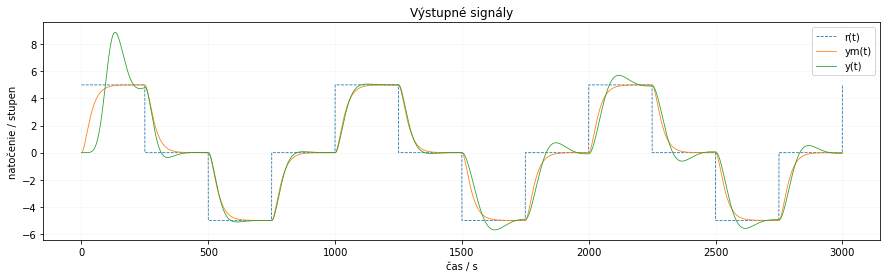

In [24]:
plt.figure(figsize=(15, 4))
plt.plot(t_log,sig_r_ext*180/np.pi, '--',linewidth=0.8)
plt.plot(t_log,x_m_log[:,0]*180/np.pi, linewidth=0.8)
plt.plot(t_log,y_log*180/np.pi, linewidth=0.8)

plt.xlabel('čas / s')
plt.ylabel('natočenie / stupen')
plt.legend(['r(t)','ym(t)','y(t)'])
plt.title('Výstupné signály')
plt.grid(alpha=0.1)

plt.savefig('C:/Users/Niki/Downloads/ADRIA-master/ADRIA-master/doc/AR04_txt_MRAC_gradientny/signalchange.png')

In [25]:
np.size(y_log)

6001

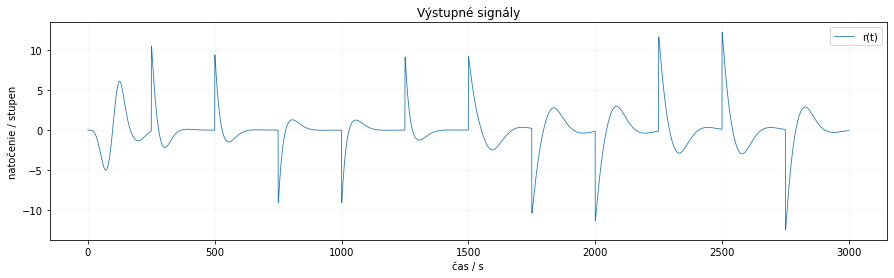

In [26]:
plt.figure(figsize=(15, 4))
plt.plot(t_log,u_log[:,0]*180/np.pi, linewidth=0.8)


plt.xlabel('čas / s')
plt.ylabel('natočenie / stupen')
plt.legend(['r(t)','ym(t)','y(t)'])
plt.title('Výstupné signály')
plt.grid(alpha=0.1)

plt.savefig('C:/Users/Niki/Downloads/ADRIA-master/ADRIA-master/doc/AR04_txt_MRAC_gradientny/signalchange2.png')

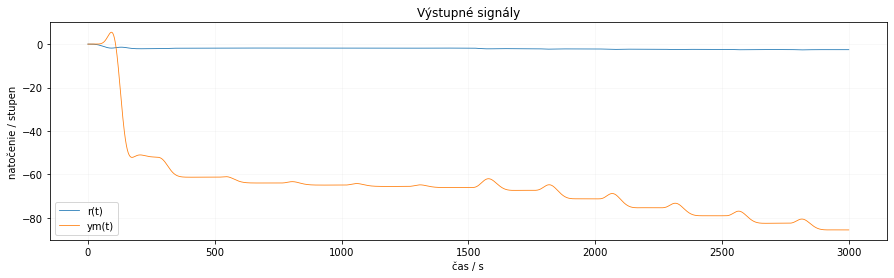

In [27]:
plt.figure(figsize=(15, 4))
plt.plot(t_log,Theta_log, linewidth=0.8)

plt.xlabel('čas / s')
plt.ylabel('natočenie / stupen')
plt.legend(['r(t)','ym(t)','y(t)'])
plt.title('Výstupné signály')
plt.grid(alpha=0.1)

plt.savefig('C:/Users/Niki/Downloads/ADRIA-master/ADRIA-master/doc/AR04_txt_MRAC_gradientny/signalchange3.png')

# Len simulacia

In [59]:
def plantFcns(x, t, A, b, u):
    dotx = np.dot(A, x) + np.dot(b, u)
    return dotx   


def fcn_simSch2(t_start, T_s, finalIndex, sig_r_ext):

    #-----------------------------------------

    par_L = 161.0
    par_K_0 = -3.86
    par_tau_10 = 5.66
    par_v = 6.0
    
    
    par_K = par_K_0 * (par_v/par_L)
    par_tau_1 = par_tau_10 * (par_L/par_v)

    par_b_0 = par_K/par_tau_1
    par_a_1 = 1.0/par_tau_1

    A = np.array([[0, 1], [0, -par_a_1]])
    b = np.array([[0], [par_b_0]])
    c = np.array([[1], [0]])



    #-----------------------------------------
    t_log = np.zeros([finalIndex, 1])
    t_log[0,:] = t_start

    #-----------------------------------------


    #-------------------------
    x_0 = np.zeros(b.shape[0])

    x_log = np.zeros([finalIndex, len(x_0)])
    x_log[0,:] = x_0

    y_log = np.zeros([finalIndex, 1])
    y_log[0,:] = np.dot(c.T, x_0.reshape(-1,1))
    
    #-------------------------
    u_log = np.zeros([finalIndex, 1])
    u_log[0,:] = 0





    #-----------------------------------------
    timespan = np.zeros(2)
    for idx in range(1, int(finalIndex)):

        timespan[0] = t_log[idx-1,:]
        timespan[1] = t_log[idx-1,:] + T_s

        t_log[idx,:] = timespan[-1]

        # ------------
        u
        odeOut = odeint(plantFcns,
                        x_log[idx-1,:],
                        timespan,
                        args=(A, b, u_log[idx-1,:])
                        )

        x_log[idx,:] = odeOut[-1,:]
        y_log[idx,:] = np.dot(c.T, x_log[idx,:].reshape(-1,1))


        # print -x_log[idx-1,1]



    return [t_log, x_log, y_log, u_log]

In [60]:
sim_t_start = 0
sim_t_final = 3000
sim_T_s = 0.5
sim_finalIndex = int(((sim_t_final - sim_t_start)/sim_T_s) + 1)

#--------------------

# Preddefinovane signaly

period_time = 1000
period_tab = np.array([
                      [0, 5.0*np.pi/180],
                      [250, 0],
                      [500, -5.0*np.pi/180],
                      [750, 0],
                      ])

sig_vysl = np.zeros([sim_finalIndex, 1])

for period in range(int(sim_t_final/period_time) + 1):


    for idx in range( int((period*period_time)/sim_T_s), int((period*period_time + period_time)/sim_T_s)):

        lastValue = period_tab[:,1][(period_tab[:,0] + (period*period_time))<=idx*sim_T_s ][-1]
        try:
            sig_vysl[idx] = lastValue
        except:
            break


# %% --------------------------------------------------------------------------

sig_r_ext = sig_vysl

# %% ---------------------------------------------------------------------------

par_v = 6

# Spustenie simulacie

t_log, x_log, y_log, u_log = fcn_simSch2(
    sim_t_start,
    sim_T_s,
    sim_finalIndex,
    sig_r_ext,
    )

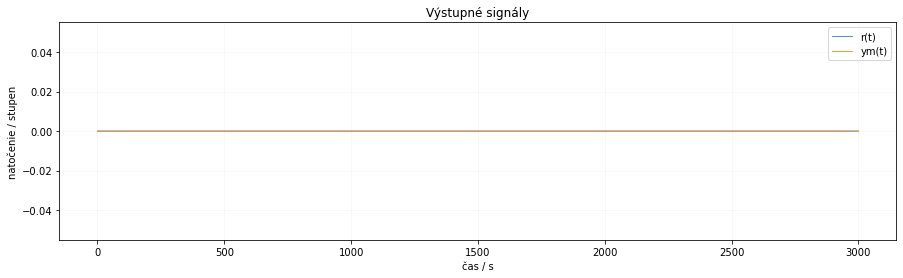

In [64]:
plt.figure(figsize=(15, 4))
plt.plot(t_log,  x_log, linewidth=0.8)

plt.xlabel('čas / s')
plt.ylabel('natočenie / stupen')
plt.legend(['r(t)','ym(t)','y(t)'])
plt.title('Výstupné signály')
plt.grid(alpha=0.1)

plt.savefig('C:/Users/Niki/Downloads/ADRIA-master/ADRIA-master/doc/AR04_txt_MRAC_gradientny/model.png')

In [69]:
import numpy as np
from scipy.integrate import odeint

import sys





# %% ---------------------------------------------------------------------------
par_L = 161.0
par_K_0 = -3.86
par_tau_10 = 5.66
par_v = 6.0


par_K = par_K_0 * (par_v/par_L)
par_tau_1 = par_tau_10 * (par_L/par_v)

par_b_0 = par_K/par_tau_1
par_a_1 = 1.0/par_tau_1

A = np.array([[0, 1], [0, -par_a_1]])
b = np.array([[0], [par_b_0]])
c = np.array([[1], [0]])


# %% ---------------------------------------------------------------------------
                                                                ### cellB c01 ###
def fcn_difRovnice(x, t, u):

    dotx = np.dot(A,x) + np.dot(b,u)

    return dotx                                                 ### cellE c01 ###






# %% ---------------------------------------------------------------------------
                                                                ### cellB c02 ###
def fcn_simSch_01_zaklad(t_start, T_s, finalIndex, sig_u_ext):

    #-----------------------------------------
    t_log = np.zeros([finalIndex, 1])
    t_log[0,:] = t_start

    #-----------------------------------------
    x_0 = np.array([0, 0])

    x_log = np.zeros([finalIndex, len(x_0)])
    x_log[0,:] = x_0

    #-----------------------------------------


    #-----------------------------------------
    timespan = np.zeros(2)
    for idx in range(1, int(finalIndex)):

        timespan[0] = t_log[idx-1,:]
        timespan[1] = t_log[idx-1,:] + T_s

        u = sig_u_ext[idx-1,:]

        odeOut = odeint(fcn_difRovnice,
                        x_log[idx-1,:],
                        timespan,
                        args=(u,)
                        )

        x_log[idx,:] = odeOut[-1,:]
        t_log[idx,:] = timespan[-1]

    return [t_log, x_log]                                       ### cellE c02 ###






# %% ---------------------------------------------------------------------------


sim_t_start = 0
sim_t_final = 3000
sim_T_s = 0.5
sim_finalIndex = int(((sim_t_final - sim_t_start)/sim_T_s) + 1)

#--------------------

# Preddefinovane signaly

period_time = 1000
tab_delt_u = np.array([
                      [0, 5.0*np.pi/180],
                      [250, 0],
                      [500, -5.0*np.pi/180],
                      [750, 0],
                      ])



sig_delt_u = np.zeros([sim_finalIndex, 1])
for idx in range(sig_delt_u.shape[0]):
    lastValue = tab_delt_u[:,1][tab_delt_u[:,0]<=idx*sim_T_s ][-1]
    sig_delt_u[idx] = lastValue

sig_u_ext = sig_delt_u 


# %% ---------------------------------------------------------------------------
                                                                ### cellB c05 ###
# Spustenie simulacie

t_log, x_log = fcn_simSch_01_zaklad(
                    sim_t_start,
                    sim_T_s,
                    sim_finalIndex,
                    sig_u_ext,
                    )                                           ### cellE c05 ###





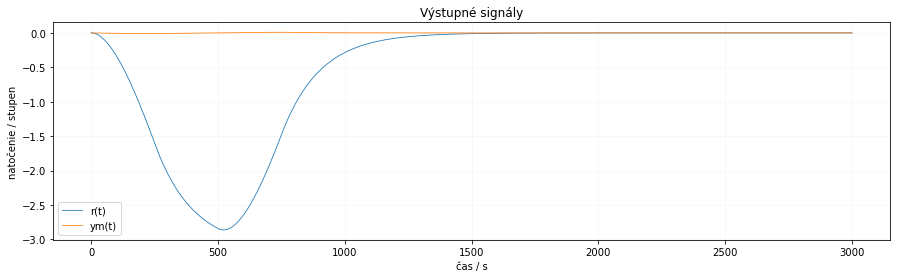

In [70]:
plt.figure(figsize=(15, 4))
plt.plot(t_log,  x_log, linewidth=0.8)

plt.xlabel('čas / s')
plt.ylabel('natočenie / stupen')
plt.legend(['r(t)','ym(t)','y(t)'])
plt.title('Výstupné signály')
plt.grid(alpha=0.1)

plt.savefig('C:/Users/Niki/Downloads/ADRIA-master/ADRIA-master/doc/AR04_txt_MRAC_gradientny/model.png')

# Neadaptivne

In [61]:
def plantFcns(x, t, A, b, u):
    dotx = np.dot(A, x) + np.dot(b, u)
    return dotx   


def fcn_simSch2(t_start, T_s, finalIndex, sig_r_ext):

    #-----------------------------------------

    par_L = 161.0
    par_K_0 = -3.86
    par_tau_10 = 5.66
    par_v = 4.0
    
    
    par_K = par_K_0 * (par_v/par_L)
    par_tau_1 = par_tau_10 * (par_L/par_v)

    par_b_0 = par_K/par_tau_1
    par_a_1 = 1.0/par_tau_1

    A = np.array([[0, 1], [0, -par_a_1]])
    b = np.array([[0], [par_b_0]])
    c = np.array([[1], [0]])

    A_m = np.array([[0, 1], [-0.0025, -0.1]])
    b_m = np.array([[0], [0.0025]])

    #-----------------------------------------
    t_log = np.zeros([finalIndex, 1])
    t_log[0,:] = t_start

    #-----------------------------------------
    x_m_0 = np.zeros(b_m.shape[0])

    x_m_log = np.zeros([finalIndex, len(x_m_0)])
    x_m_log[0,:] = x_m_0

    #-------------------------
    x_0 = np.zeros(b.shape[0])

    x_log = np.zeros([finalIndex, len(x_0)])
    x_log[0,:] = x_0

    y_log = np.zeros([finalIndex, 1])
    y_log[0,:] = np.dot(c.T, x_0.reshape(-1,1))
    
    #-------------------------
    u_log = np.zeros([finalIndex, 1])
    u_log[0,:] = 0

    xf1_log = np.zeros([finalIndex, b_m.shape[0]])
    xf2_log = np.zeros([finalIndex, b_m.shape[0]])


    Theta_log = np.zeros([finalIndex, 2])
    Theta_log = np.array([-3.8009, -143.6921])



    #-----------------------------------------
    timespan = np.zeros(2)
    for idx in range(1, int(finalIndex)):
        #-----------------------------------
        
        timespan[0] = t_log[idx-1,:]
        timespan[1] = t_log[idx-1,:] + T_s

        t_log[idx,:] = timespan[-1]

        # ------------

        odeOut = odeint(plantFcns,
                        x_m_log[idx-1,:],
                        timespan,
                        args=(A_m, b_m, sig_r_ext[idx-1,:])
                        )

        x_m_log[idx,:] = odeOut[-1,:]
        
        odeOut = odeint(plantFcns,
                        x_log[idx-1,:],
                        timespan,
                        args=(A, b, u_log[idx-1,:])
                        )

        x_log[idx,:] = odeOut[-1,:]

        y_log[idx,:] = np.dot(c.T, x_log[idx,:].reshape(-1,1))



        # ------------


        # print -x_log[idx-1,1]

        omega = np.array([sig_r_ext[idx-1,:] - y_log[idx-1,:], [-x_log[idx-1,1]]])

        u_log[idx,:] = np.dot(Theta_log.T, omega)


    return [t_log, x_m_log, x_log, y_log, u_log, Theta_log, xf1_log, xf2_log]

In [62]:
sim_t_start = 0
sim_t_final = 3000
sim_T_s = 0.5
sim_finalIndex = int(((sim_t_final - sim_t_start)/sim_T_s) + 1)

#--------------------

# Preddefinovane signaly

period_time = 1000
period_tab = np.array([
                      [0, 5.0*np.pi/180],
                      [250, 0],
                      [500, -5.0*np.pi/180],
                      [750, 0],
                      ])

sig_vysl = np.zeros([sim_finalIndex, 1])

for period in range(int(sim_t_final/period_time) + 1):


    for idx in range( int((period*period_time)/sim_T_s), int((period*period_time + period_time)/sim_T_s)):

        lastValue = period_tab[:,1][(period_tab[:,0] + (period*period_time))<=idx*sim_T_s ][-1]
        try:
            sig_vysl[idx] = lastValue
        except:
            break


# %% --------------------------------------------------------------------------

sig_r_ext = sig_vysl

# %% ---------------------------------------------------------------------------

par_v = 4

# Spustenie simulacie

t_log, x_m_log, x_log, y_log, u_log, Theta_log, xf1_log, xf2_log = fcn_simSch2(
    sim_t_start,
    sim_T_s,
    sim_finalIndex,
    sig_r_ext,
    )

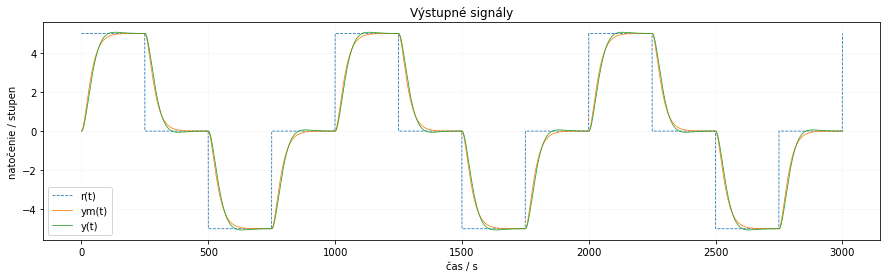

In [63]:
plt.figure(figsize=(15, 4))
plt.plot(t_log,sig_r_ext*180/np.pi, '--',linewidth=0.8)
plt.plot(t_log,x_m_log[:,0]*180/np.pi, linewidth=0.8)
plt.plot(t_log,y_log*180/np.pi, linewidth=0.8)

plt.xlabel('čas / s')
plt.ylabel('natočenie / stupen')
plt.legend(['r(t)','ym(t)','y(t)'])
plt.title('Výstupné signály')
plt.grid(alpha=0.1)
plt.savefig('C:/Users/Niki/Downloads/ADRIA-master/ADRIA-master/doc/AR04_txt_MRAC_gradientny/neadaptivny.png')